# Spectral accuracy

Let's interpolate a function using FFTs, and see how the error decays spectrally. The algorithm will look like this:

* Compute values of $f(x)$ at discrete points $x_i$
* Compute FFT for $\hat{f}(k)$
* Compute the inverse FFT to compute $f(x)$ at sample points $x_j$


In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline


def interpolate(f, N, N_eval):
    """
    Uses FFT on N equidistant points to interpolate f at N_eval equidistant points 
    Inputs:
    ------
        f: (array of float) value of function at N equidistant points 
        N: (int) number of points for FFT
   N_eval: (int) number of interpolation points
    """
    
    f_hat = numpy.fft.rfft(f)
    f_eval = N_eval*1./N*numpy.fft.irfft(f_hat, N_eval)
    
    return f_eval

Let's interpolate the function $f(x) = \frac{1}{1+\sin^2(x)}$ for $0<x<2\pi$, for $N=32$ and $N_\text{eval}=1024*N$

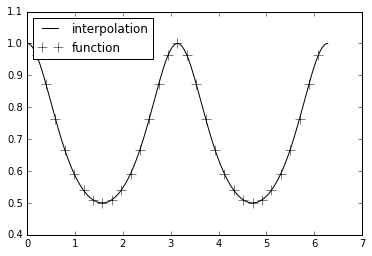

In [2]:
N=32
L = 2*numpy.pi
x0 = 0.
x = numpy.linspace(x0, x0+L, N, endpoint=False)

N_eval = N*1024
x_eval = numpy.linspace(x0, x0+L, N_eval, endpoint=False)

f = 1./(1.+numpy.sin(x)**2)

f_eval = interpolate(f, N, N_eval)

pyplot.plot(x_eval, f_eval, c='k', ls='-', label='interpolation')
pyplot.plot(x, f, c='k', ls='', marker='+', ms=10, label='function')
pyplot.legend(loc='best')

The interpolation looks good! Let's see how the error looks for different values of $N$.

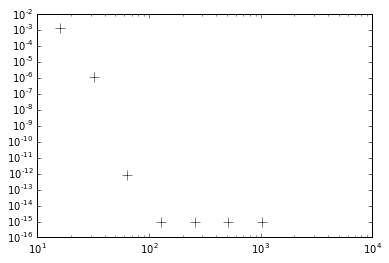

In [3]:
def L2_error(f, f_exact):
    return numpy.sqrt(numpy.sum((f-f_exact)**2)/numpy.sum(f_exact**2))

def max_error(f,f_exact):
    return numpy.max(numpy.sqrt((f-f_exact)**2))

def point_error(f,f_exact):
    return f-f_exact

def function_1(x):
    return 1/(1+numpy.sin(x)**2)
    

def convergence_test(N_array, function, x0, L):

    error = numpy.array([])
    for N in N_array:
    
        x = numpy.linspace(x0, x0+L, N, endpoint=False)
    
        N_eval = N_array[-1]*1024
        x_eval = numpy.linspace(x0, x0+L, N_eval, endpoint=False)
    
        f = 1/(1+numpy.sin(x)**2)
        f_eval = interpolate(f, N, N_eval)
    
        f_exact = 1/(1+numpy.sin(x_eval)**2)    
    
        e = max_error(f_eval, f_exact)
    
        error = numpy.append(error,e)    

    pyplot.loglog(N_array, error, ls='', marker='+', c='k', ms=10)

N_array = numpy.array([16, 32, 64, 128, 256, 512, 1024])
x0 = 0.
L  = 2*numpy.pi
convergence_test(N_array, function_1, x0, L)

That looks spectral to me! 

## The Runge phenomenon

Let's try a different function: $f(x) = \frac{1}{1+16x^2}$. 

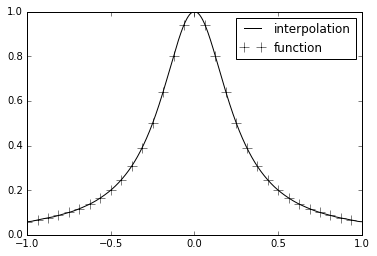

In [4]:
def function_2(x):
    return 1./(1.+16*x**2)

N=32
L = 2.
x0 = -1.
x = numpy.linspace(x0, x0+L, N, endpoint=False)

N_eval = N*1024
x_eval = numpy.linspace(x0, x0+L, N_eval, endpoint=False)

f = function_2(x)

f_eval = interpolate(f, N, N_eval)

pyplot.plot(x_eval, f_eval, c='k', ls='-', label='interpolation')
pyplot.plot(x, f, c='k', ls='', marker='+', ms=10, label='function')
pyplot.legend(loc='best')

That looks good too! Convergence?

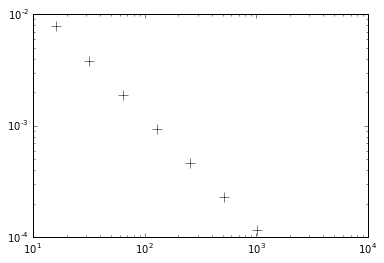

In [5]:
N_array = numpy.array([16, 32, 64, 128, 256, 512, 1024])
x0 = -1.
L  = 2.
convergence_test(N_array, function_2, x0, L)

Well, that doesn't look that good. Error does decay, but we lost the spectral convergence. What's going on?
Let's look closer at the pointwise error of the previous case

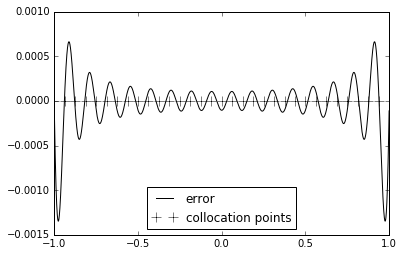

In [6]:
f_exact = function_2(x_eval)

pyplot.plot(x_eval, f_eval-f_exact, c='k', ls='-', label='error')
pyplot.plot(x, numpy.zeros(N), c='k', ls='', marker='+', ms=10, label='collocation points')
pyplot.legend(loc='best')

Oscillations! What happens if we refine, say 4 times?

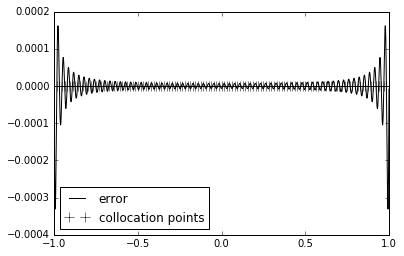

In [7]:
N = 128
x = numpy.linspace(x0, x0+L, N, endpoint=False)

N_eval = N*1024
x_eval = numpy.linspace(x0, x0+L, N_eval, endpoint=False)

f = function_2(x)

f_eval = interpolate(f, N, N_eval)
f_exact = function_2(x_eval)

pyplot.plot(x_eval, f_eval-f_exact, c='k', ls='-', label='error')
pyplot.plot(x, numpy.zeros(N), c='k', ls='', marker='+', ms=10, label='collocation points')
pyplot.legend(loc='best')

It gets worse! What is going on? The function is periodic, but if we draw the function in the next "period", we realize that it is nonsmooth, as the derivative is different on both sides of the function. We'll talk about this more in class, and it's called Runge phenomenon.

### Clustered grids

One alternative to overlook this problem is to use clustered grids. The most popular of them are the Chebyshev nodes

\begin{equation}
x_j = \cos(j\pi/N)
\end{equation}

However, we need to rethink our FFT, as nodes are not equidistant.

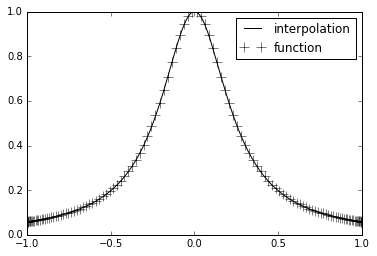

In [48]:
import scipy.fftpack

def interpolate_dct(f, N, N_eval):
    
    f_hat = scipy.fftpack.dct(f)
    f_eval = 1./(2*N)*scipy.fftpack.idct(f_hat, n=N_eval)
    
    return f_eval

N=128

x_cheb = numpy.cos(numpy.linspace(0.,1.,N)*numpy.pi)
#pyplot.plot(x_cheb,numpy.zeros(N),marker='+',ls='')

f_cheb = function_2(x_cheb)

N_eval = N*1024

f_eval = interpolate_dct(f_cheb, N, N_eval)

x_cheb_eval = numpy.cos(numpy.linspace(0.,1.,N_eval)*numpy.pi)

f_exact = function_2(x_cheb_eval)

pyplot.plot(x_cheb_eval, f_eval, c='k', ls='-', label='interpolation')
pyplot.plot(x_cheb, f_cheb, c='k', ls='', marker='+', ms=10, label='function')
pyplot.legend(loc='best')

Looks good! Let's see the error

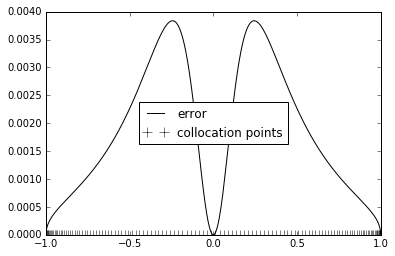

In [49]:
pyplot.plot(x_cheb_eval, f_exact-f_eval, c='k', ls='-', label='error')
pyplot.plot(x_cheb, numpy.zeros(len(x_cheb)), c='k', ls='', marker='+', ms=10, label='collocation points')
pyplot.legend(loc='best')

Convergence test?

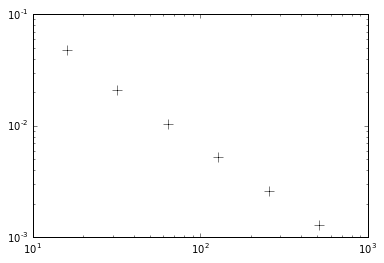

In [53]:
def convergence_test_cheb(N_array, function):

    error = numpy.array([])
    for N in N_array:
    
        x_cheb = numpy.cos(numpy.linspace(0.,1.,N)*numpy.pi)
    
        N_eval = N_array[-1]*128
        x_cheb_eval = numpy.cos(numpy.linspace(0.,1.,N_eval)*numpy.pi)
        
        f = function(x_cheb)
        f_eval = interpolate_dct(f, N, N_eval)
    
        f_exact = function_2(x_cheb_eval)
        e = L2_error(f_eval, f_exact)
    
        error = numpy.append(error,e)    

    pyplot.loglog(N_array, error, ls='', marker='+', c='k', ms=10)

N_array = numpy.array([16, 32, 64, 128, 256, 512])
convergence_test_cheb(N_array, function_2)

## The Gibbs phenomenon

What about discontinuities?

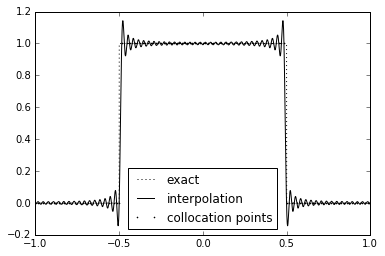

In [11]:
def function_3(x):
    f = numpy.zeros(len(x))
    f[numpy.where(numpy.logical_and(x>-0.5,x<0.5))[0]] = 1.
    
    return f

f = function_3(x)
f_eval = interpolate(f, N, N_eval)

x_eval = numpy.linspace(x0, x0+L, N_eval, endpoint=False)
f_exact = function_3(x_eval)

pyplot.plot(x_eval, f_exact, c='k', ls=':', label='exact')
pyplot.plot(x_eval, f_eval, c='k', ls='-', label='interpolation')
pyplot.plot(x, f, c='k', ls='', marker='+', ms=2, label='collocation points')
pyplot.legend(loc='best')

Yup, that doesn't look right either. These oscillations are known as the Gibbs phenomenon.